# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve)
from collections import Counter

In [2]:
data = pd.read_csv('/kaggle/input/bengali-sms-dataset/bangla_smish.csv')
data.rename(columns={'label': 'Label'}, inplace=True)
data

,Label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...
...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ..."
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!
2285,normal,আপনার কেমন দিন কাটছে?


In [3]:
data.head()

,Label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...


In [4]:
data.shape

(2287, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287 entries, 0 to 2286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   2287 non-null   object
 1   text    2287 non-null   object
dtypes: object(2)
memory usage: 35.9+ KB


In [6]:
def clean_text(text):
    text = re.sub('[^\u0980-\u09FF]',' ',text)
    text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_৳]', '', text)
    text = re.sub(r'(\W)(?=\1)', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'ߑͰߑ̰ߒנ', '', text)
    text = re.sub(r'ߎɰߎɰߎɍ', '', text)
    return text

In [7]:
data['Cleaned'] = data['text'].apply(clean_text)
data['length'] = data['Cleaned'].str.split().apply(len)
dataset = data[data['length'] > 0].reset_index(drop=True)
print(f"After Cleaning:\nRemoved {len(data) - len(dataset)} small texts\nTotal Texts: {len(dataset)}")

After Cleaning:
Removed 8 small texts
Total Texts: 2279


In [8]:
data

,Label,text,Cleaned,length
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা জরুরি...,9
1,normal,আপনার দিন কেমন কাটছে?,আপনার দিন কেমন কাটছে,4
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",৪৫ ক্যাশব্যাক ৪৬জিবি ৪৫৩ ৩০দিন নিয়ে নাও এখনই,8
3,normal,"হ্যালো, কি খবর?",হ্যালো কি খবর,3
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে কল করুন,7
...,...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস সহ ৩জিবি ৬০টাকা ৩দিন ডায়াল ১২১ ৫৬৯৯ বা,9
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",নতুন স্যামসাং ফোনে ১০ ডিসকাউন্ট স্টক সীমিত আজই...,9
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা,4
2285,normal,আপনার কেমন দিন কাটছে?,আপনার কেমন দিন কাটছে,4


In [9]:
stopword_ls ='/kaggle/input/stop-words/stopwords-bn.txt'

In [10]:
def stopword_removal(text,stpwrd= stopword_ls):
    stp,num_of_stopwords =stopwords_info(stpwrd)
    result = text.split()
    Comments = [word.strip() for word in result if word not in stp ]
    Comments =" ".join(Comments)
    return Comments

In [11]:
def stopwords_info(filename):
    stp = open(filename,'r',encoding='utf-8').read().split()
    num_of_stopwords = len(stp)
    return stp,num_of_stopwords

In [12]:
data['Cleaned'] = data['Cleaned'].apply(stopword_removal)  
data

,Label,text,Cleaned,length
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক গুরুত্বপূর্ণ বার্তা জরুরি ভিত্...,9
1,normal,আপনার দিন কেমন কাটছে?,কেমন কাটছে,4
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",৪৫ ক্যাশব্যাক ৪৬জিবি ৪৫৩ ৩০দিন নাও এখনই,8
3,normal,"হ্যালো, কি খবর?",হ্যালো খবর,3
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা কল করুন,7
...,...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস ৩জিবি ৬০টাকা ৩দিন ডায়াল ১২১ ৫৬৯৯,9
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",স্যামসাং ফোনে ১০ ডিসকাউন্ট স্টক সীমিত আজই কিনুন,9
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা,4
2285,normal,আপনার কেমন দিন কাটছে?,কেমন কাটছে,4


In [13]:
data['length'] = data['Cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 28 Small Text 
Total Text: 2259


In [14]:
def data_summary(df):
    class_counts = df['Label'].value_counts()
    total_unique_words = set(word for text in df['Cleaned'] for word in text.lower().split())
    print(f"Total Unique Words: {len(total_unique_words)}\n")
    
    for label, count in class_counts.items():
        subset = df[df['Label'] == label]
        words = [word for text in subset['Cleaned'] for word in text.lower().split()]
        word_counts = Counter(words)
        unique_words = len(word_counts)
        most_common = word_counts.most_common(10)
        
        print(f"Class: {label}")
        print(f"Documents: {count}")
        print(f"Words: {len(words)}")
        print(f"Unique Words: {unique_words}\n")
        print("Most Frequent Words:")
        for word, freq in most_common:
            print(f"{word}: {freq}")
        print()

data_summary(dataset)

Total Unique Words: 3320

Class: smish
Documents: 909
Words: 9529
Unique Words: 1625

Most Frequent Words:
করুন: 796
টাকা: 355
ক্লিক: 286
কল: 238
ব্যাংক: 144
ইনকাম: 125
০০০: 121
বিস্তারিত: 109
বাজি: 97
ধরুন: 97

Class: normal
Documents: 904
Words: 3660
Unique Words: 1185

Most Frequent Words:
নাম্বারে: 98
টাকা: 94
কেমন: 93
করুন: 79
শুভ: 70
না: 54
ভালো: 52
কল: 43
খবর: 41
আছি: 38

Class: promo
Documents: 446
Words: 4009
Unique Words: 1122

Most Frequent Words:
৩০দিন: 152
১২১: 75
ক্যাশব্যাক: 71
নাও: 70
ডায়াল: 70
করুন: 59
অফার: 56
বোনাস: 46
ছাড়: 45
ডিসকাউন্ট: 45



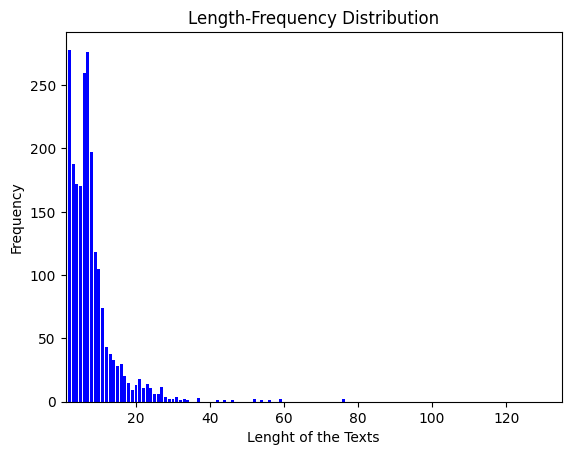

Maximum Length of a Text: 76
Minimum Length of a Text: 1
Average Length of a Text: 8.0


In [16]:
dataset['TextLength'] = dataset.Cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

In [18]:
dataset.groupby('Label').size().reset_index(name='counts')

,Label,counts
0,normal,904
1,promo,446
2,smish,909


# 0 = Normal, 1 = Promo, 2 = Smish

In [19]:
le = LabelEncoder()
dataset['Encoded_Label'] = le.fit_transform(dataset['Label'])
print(f"Classes: {le.classes_}")

Classes: ['normal' 'promo' 'smish']


In [25]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x.split(), use_idf=True, token_pattern=None)
X = tfidf.fit_transform(dataset['Cleaned'])
y = dataset['Encoded_Label'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=22, stratify=y
)
print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 1807, Testing Samples: 452


In [27]:
models = {
    'Logistic Regression': LogisticRegression(random_state=123, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=1, min_samples_split=25),
    'Random Forest': RandomForestClassifier(criterion='entropy', random_state=13),
    'Naive Bayes': MultinomialNB(alpha=0.431),
    'KNN': KNeighborsClassifier(n_neighbors=100, algorithm='ball_tree', n_jobs=-1),
    'Linear SVM': SVC(kernel='linear', C=0.2, probability=True, random_state=0),
    'RBF SVM': SVC(kernel='rbf', C=1000, gamma=0.00015, probability=True, random_state=0),
    'SGD': SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3)
}

In [24]:
import warnings
warnings.filterwarnings('ignore')

performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance[name] = {
        'Accuracy': accuracy_score(y_test, y_pred) * 100,
        'Precision': precision_score(y_test, y_pred, average='micro') * 100,
        'Recall': recall_score(y_test, y_pred, average='micro') * 100,
        'F1 Score': f1_score(y_test, y_pred, average='micro') * 100
    }
    print(f"{name} evaluated.")

Logistic Regression evaluated.
Decision Tree evaluated.
Random Forest evaluated.
Naive Bayes evaluated.
KNN evaluated.
Linear SVM evaluated.
RBF SVM evaluated.
SGD evaluated.


In [28]:
performance_df = (
    pd.DataFrame(performance)
    .T[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
    .round(2)
    .style
    .apply(
        lambda s: ['background-color: lightgreen' if v == s.max() else '' for v in s],
        subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        axis=0
    )
    .format(precision=2)
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
)

performance_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,94.91,94.91,94.91,94.91
Decision Tree,68.81,68.81,68.81,68.81
Random Forest,96.02,96.02,96.02,96.02
Naive Bayes,96.46,96.46,96.46,96.46
KNN,88.72,88.72,88.72,88.72
Linear SVM,93.36,93.36,93.36,93.36
RBF SVM,93.81,93.81,93.81,93.81
SGD,97.12,97.12,97.12,97.12


 # EDA